In [4]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from scipy.linalg import norm

In [ ]:
from recommendations_project import *

**PLEASE** save this file right now using the following naming convention: `NUMBER_FOR_SORTING-YOUR_INITIALS-SHORT_DESCRIPTION`, e.g. `1.0-fw-initial-data-exploration`. Use the number to order the file within the directory according to its usage.

# Description

**ENG:**

Requirement:

For this problem need to construct `recommendation system` on base of views and likes logs.

Views and likes logs constructed by 4 columns:
- `user_id` - user indentificator;
- `item_id` - banner identificator;
- `like` - flag of likes and views (view without like);
- `timestamp` - time in unix seconds.

For users and items there are features (latent features) with dimension 32.
You need to predict 20 banners for users. Quality is measured by percentage of liked by users banners from recommended list (top-20 accuracy).

`train.csv` - training dataset;
`item-features` - features for banners;
`user-features` - features for users.

Quality of solution is rated by Top-K metrics, where k=20.    

**RUS:**

Условия

Для данной задачи вам предстоит построить `рекомендательную систему баннеров` на основе `логов просмотров и лайков`.

Логи представлены четырьмя колонками:

- `user_id` (идентификатор пользователя),
- `item_id` (идентификатор баннера),
- `like` (флаг понравился ли пользователю баннер),
- `timestamp` (unix время в секундах совершения действия).
Кроме того, для пользователей и баннеров имеются признаки размерностью 32.

Вам необходимо предсказать 20 баннеров для пользователей. Качество решения будет оцениваться как доля "лайкнутых" пользователей баннеров из предложенного вами списка (top-20 accuracy).

Описание файлов
`test.csv` — тестовый файл, содержащий идентификаторы пользователи, для которых необходимо сделать предсказания

`train.csv` — обучающий датасет

`item-features.csv` — признаки для баннеров

`user-features` — признаки для пользователей

`sample-submission.csv` — пример решения (сабмита).

качество решения оценивается по метрике Top-K Accuracy, где k = 20. Код:

# Data

In [6]:
print("List of of raw data:")
PATH_TO_DATA = '../data/raw/'
!ls $PATH_TO_DATA

List of of raw data:
item-features.csv  test.csv  train.csv	user-features.csv


In [7]:
print("Structure of 'user-features' table:")
UF_data = (pd.read_csv(os.path.join(os.path.abspath(PATH_TO_DATA), 'user-features.csv'))).sort_values(by='user_id')
display(UF_data.head())
print("Every user has 32 features. Vector of features describes user preferences in space of features.")
UF = UF_data[UF_data.columns[1:]].values
print(f'User-Feature matrix has shape {UF.shape}.')

Structure of 'user-features' table:


,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,0,0.000695,-0.001573,-0.001470,0.002085,-0.000498,0.000685,0.000811,0.000666,-0.003031,-0.003031,0.003419,0.000290,0.002290,0.001305,0.000772,-0.002100,-0.000179,-0.001676,-0.000888,-0.000888,-0.000743,-0.003181,-0.004196,-0.000698,0.001121,-0.001079,-0.001993,-0.001993,0.000422,-0.001168,-0.001168,0.000297
1,1,0.001204,-0.002725,-0.002546,0.003612,-0.000862,0.001187,0.001404,0.001154,-0.005251,-0.005251,0.005921,0.000502,0.003966,0.002260,0.001337,-0.003637,-0.000310,-0.002904,-0.001539,-0.001539,-0.001286,-0.005510,-0.007268,-0.001209,0.001942,-0.001870,-0.003451,-0.003451,0.000732,-0.002023,-0.002023,0.000515
2,2,0.000491,-0.001112,-0.001039,0.001475,-0.000352,0.000484,0.000573,0.000471,-0.002144,-0.002144,0.002417,0.000205,0.001619,0.000923,0.000546,-0.001485,-0.000126,-0.001185,-0.000628,-0.000628,-0.000525,-0.002250,-0.002967,-0.000494,0.000793,-0.000763,-0.001409,-0.001409,0.000299,-0.000826,-0.000826,0.000210
3,3,0.000777,-0.001759,-0.001643,0.002332,-0.000557,0.000766,0.000906,0.000745,-0.003389,-0.003389,0.003822,0.000324,0.002560,0.001459,0.000863,-0.002348,-0.000200,-0.001874,-0.000993,-0.000993,-0.000830,-0.003557,-0.004691,-0.000781,0.001254,-0.001207,-0.002228,-0.002228,0.000472,-0.001306,-0.001306,0.000332
4,4,0.000695,-0.001573,-0.001470,0.002085,-0.000498,0.000685,0.000811,0.000666,-0.003031,-0.003031,0.003419,0.000290,0.002290,0.001305,0.000772,-0.002100,-0.000179,-0.001676,-0.000888,-0.000888,-0.000743,-0.003181,-0.004196,-0.000698,0.001121,-0.001079,-0.001993,-0.001993,0.000422,-0.001168,-0.001168,0.000297


Every user has 32 features. Vector of features describes user preferences in space of features.
User-Feature matrix has shape (497, 32).


In [8]:
print('Vectors of preferencies have different lengthes.')
print('Example of 5 vectors:')
display([norm(x) for x in UF[:5]])

Vectors of preferencies have different lengthes.
Example of 5 vectors:


[0.00999676350828053,
 0.01731490230759232,
 0.007068779266623366,
 0.011176721379752248,
 0.00999676350828053]

In [9]:
print('The same picture for item-feature table:')
IF_data = (pd.read_csv(os.path.join(os.path.abspath(PATH_TO_DATA), 'item-features.csv'))).sort_values(by='item_id')
display(IF_data.head())
print("Every item has 32 features. Vector of features describes item in space of features.")
IF = IF_data[IF_data.columns[1:]].values
print(f'User-Feature matrix has shape {IF_data.shape}.')

The same picture for item-feature table:


,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
388,0,0.001433,-0.003243,-0.003030,0.004299,-0.001026,0.001412,0.001671,0.001373,-0.006249,-0.006249,0.007048,0.000598,0.004721,0.002690,0.001591,-0.004329,-0.000369,-0.003456,-0.001831,-0.001831,-0.001531,-0.006559,-0.008651,-0.001440,0.002312,-0.002225,-0.004108,-0.004108,0.000871,-0.002408,-0.002408,0.000613
169,1,0.002482,-0.005617,-0.005248,0.007446,-0.001777,0.002446,0.002895,0.002378,-0.010824,-0.010824,0.012207,0.001035,0.008177,0.004659,0.002756,-0.007498,-0.000639,-0.005986,-0.003172,-0.003172,-0.002652,-0.011360,-0.014983,-0.002493,0.004004,-0.003855,-0.007115,-0.007115,0.001508,-0.004171,-0.004171,0.001062
239,2,0.001871,-0.004236,-0.003958,0.005615,-0.001340,0.001845,0.002183,0.001793,-0.008162,-0.008162,0.009205,0.000781,0.006166,0.003513,0.002078,-0.005654,-0.000482,-0.004514,-0.002392,-0.002392,-0.002000,-0.008566,-0.011299,-0.001880,0.003020,-0.002907,-0.005365,-0.005365,0.001137,-0.003145,-0.003145,0.000801
425,3,0.001390,-0.003146,-0.002940,0.004171,-0.000996,0.001370,0.001622,0.001332,-0.006063,-0.006063,0.006837,0.000580,0.004580,0.002610,0.001544,-0.004199,-0.000358,-0.003353,-0.001777,-0.001777,-0.001485,-0.006363,-0.008392,-0.001397,0.002243,-0.002159,-0.003985,-0.003985,0.000845,-0.002336,-0.002336,0.000595
260,4,0.001738,-0.003933,-0.003675,0.005213,-0.001244,0.001713,0.002027,0.001665,-0.007579,-0.007579,0.008546,0.000725,0.005725,0.003262,0.001930,-0.005249,-0.000447,-0.004191,-0.002221,-0.002221,-0.001857,-0.007953,-0.010490,-0.001746,0.002804,-0.002699,-0.004982,-0.004982,0.001056,-0.002920,-0.002920,0.000743


Every item has 32 features. Vector of features describes item in space of features.
User-Feature matrix has shape (444, 33).


In [10]:
print('Vectors of items have different lengthes.')
print('Example of 5 vectors:')
display([norm(x) for x in IF[:5]])

Vectors of items have different lengthes.
Example of 5 vectors:


[0.020608855929480318,
 0.03569558555572713,
 0.02691710951501933,
 0.019993527016561024,
 0.02499190877070131]

In [11]:
print('Table of logs:')
logs = (pd.read_csv(os.path.join(os.path.abspath(PATH_TO_DATA), 'train.csv'))).sort_values(by = ['timestamp'])
logs["timestamp"]= pd.to_datetime(logs["timestamp"]*10**9)
logs

Table of logs:
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,user_id,item_id,like,timestamp
0,140,342,0,2017-03-31 05:03:42
1,378,172,1,2017-03-31 05:03:48
2,150,182,0,2017-03-31 05:04:10
3,455,17,0,2017-03-31 05:05:04
4,350,409,0,2017-03-31 05:05:35
...,...,...,...,...
8669,161,312,0,2017-04-03 10:31:59
8670,406,208,0,2017-04-03 10:32:23
8671,196,43,0,2017-04-03 10:32:56
8672,84,100,0,2017-04-03 10:32:59


In [12]:
print(f'Number of users in log table equals {len(np.unique(logs.user_id))}. User-Id index starts from {np.min(logs.user_id)} to {np.max(logs.user_id)}.')

Number of users in log table equals 497. User-Id index starts from 0 to 496.


In [13]:
print(f'Number of items in log table equals {len(np.unique(logs.item_id))}. Item-Id index starts from {np.min(logs.item_id)} to {np.max(logs.item_id)}.')

Number of items in log table equals 444. Item-Id index starts from 0 to 443.


# Solution

Product of matrices `UF*IF.T` gives matrix `UI` (user-item). 

Each element in `UI` is a measure of the `user preference` for the item as the scalar product of `user-features` (as `uf`) and `item-features` (as `if`) vectors. So by element weights we can sort *item preferencies* by user. 

Each element in UI is a scalar product of `uf` and `if` vectors. Scalar product equals $cos(\alpha)*|uf|*|if|$. To rate items for the user `if` vectors should have the same lengths. So preferencies are measured by cosinuses of angles between vectors in features space.

Next step is to know how to change `UF` according user `views` and `likes`.

Each `like` should change user preferencies. Scalar product should be larger for the item and user. It can be done by decrease angle between them. For example, we can add `item-feature` vector to `user-item` with weight `w_1`. 
$$uf^{new}= \frac{(uf+w_1*if^{like})}{ |uf+w_1*if^{like}|}$$

The same step for `views`.

$$uf^{new}= \frac{(uf+w_2*if^{view})}{ |uf+w_2*if^{view}|}$$

We can assume that `w2` is too small or negative. It will be decided by quality of solution according metric top-K.

So lengths of vectors in features space is not important. Angles between vectors are important.

In [14]:
'''
    Function that normalize all vectors in the matrix A by the vector's lengths.
    Vectors stored as rows in the matrix A.
'''
def norm_matrix(A: np.array):
    B = A.copy()
    for i, vector in enumerate(A):
        B[i] = vector/norm(vector)
    return B

# Default score

In [168]:
'''
Get K indexes with max values from vector V.
V is a numpy.array with shape (1,)
'''


def get_indexes_with_max_values(V: np.array, K=20, seen=None):
    # N indexes with max values cant be more than dimension of the Vector
    N = min(K, len(V))
    U = [(i, x) for i, x in enumerate(V)]  # save indexes for Vector's values
    U = sorted(U, key=lambda x: -x[1])  # sort array by values
    I = [i for i, x in U]  # return indexes
    # filter I : remove seen
    if seen:
        for s in seen:
            if s in I:
                I.pop(I.index(s))
    return I[:N]


print("Example of using the function:")
A = np.array([6, 2, 3, 4, 5, 2000, 20, 2, 2000, 2000])
get_indexes_with_max_values(A, 5, set([5, 8, 9, 6]))

Example of using the function:


[0, 4, 3, 2, 1]

In [16]:
'''
Returns 20 banners for every `user_id` in log table.
Assume that UI matrix is a constant.
'''


def make_simple_recommendations(logs: pd.DataFrame, ui_matrix: np.array):
    result = []
    for index, row in logs.iterrows():
        preferencies = ui_matrix[
            row.user_id]  # list of user preferencies for items
        banners = get_indexes_with_max_values(
            preferencies)  # get 20 banners with max preferencies
        result.append(banners)  # save banners in result list
    return result

In [17]:
'''
Get score by likes in recommendations.
'''


def get_score(logs: pd.DataFrame, R: np.array):
    score = 0
    count = 0
    for (index, row), rs in zip(logs.iterrows(), R):
        #         print(index)
        #         print(row)
        #         print(rs)
        #         print()
        if row.like == 1 and row.item_id in rs:
            score += 1


#         if count ==10: break
#         count +=1
    likes = np.sum(logs.like)
    return score / likes

Score quality of the solution that assumes `user-features` matrix is not changing. So `user-item` matrix is not changing too.

## Examples

**no scaling**

In [18]:
UI_const = UF.dot(IF.T)

In [19]:
%%time
simple_recommendations = make_simple_recommendations(logs, UI_const)

CPU times: user 4.36 s, sys: 63.5 ms, total: 4.42 s
Wall time: 4 s


In [20]:
get_score(logs, simple_recommendations)

0.43315858453473133

**scaling UF**

In [21]:
# norm UF and IF matrices
UF_norm = norm_matrix(UF)
# calculate `user-item` matrix
UI_const = UF_norm.dot(IF.T)

In [22]:
%%time
simple_recommendations = make_simple_recommendations(logs, UI_const)

CPU times: user 4.58 s, sys: 27.5 ms, total: 4.61 s
Wall time: 4.18 s


In [23]:
get_score(logs, simple_recommendations)

0.43315858453473133

**scaling UF and IF**

In [24]:
# norm UF and IF matrices
UF_norm = norm_matrix(UF)
IF_norm = norm_matrix(IF)
# calculate `user-item` matrix
UI_const = UF_norm.dot(IF_norm.T)

In [25]:
%%time
simple_recommendations = make_simple_recommendations(logs, UI_const)

CPU times: user 4.33 s, sys: 44 ms, total: 4.37 s
Wall time: 3.95 s


In [26]:
get_score(logs, simple_recommendations)

0.08191349934469201

# Estimator : evaluate UF matrix

In [211]:
from sklearn.base import BaseEstimator


class RecommendationEstimator(BaseEstimator):
    def __init__(self,
                 UF: np.array,
                 IF: np.array,
                 w1=0,
                 w2=0,
                 remove_seen=True):
        #save parameters
        self.w1 = w1
        self.w2 = w2
        self.UF = UF
        self.IF = IF
        self.IFT = self.IF.T  # copy of transposed IF matrix
        self.remove_seen = remove_seen  # use hash of seen items or not
        self.seen = {}  # hash for seen items

        # UF matrix for fit and refit
        self.UF_ = {}
        for i, x in enumerate(norm_matrix(self.UF)):
            self.UF_[i] = x

        # copy of normed IF matrix
        self.IF_normed = {}
        for i, x in enumerate(norm_matrix(self.IF)):
            self.IF_normed[i] = x

    '''Fit and train the model: train UF-matrix according views and likes in the past time.
    X_train - is an array of user_id that is sorted by time.
    y - is the array of recommendations according likes. '''

    def fit(self, X_train: np.array, y: np.array):
        # redefine
        self.UF_ == {}  # target of fit function: evaluate it through logs
        for i, x in enumerate(norm_matrix(self.UF)):
            self.UF_[i] = x
        # redefine
        self.seen = {}

        # evaluate UF matrix:

        # assume structure of X_train : 2 colimns [user_id, timestamp]
        # assume structure of y is two columns [item_id , like
        for row, prediction in zip(X_train, y):
            # list of user preferences for items
            # first element is an user id , second is for time
            user_id = int(row[0])
            item_id = int(prediction[0])
            like = int(prediction[1])

            # user preferences
            preferences = self.UF_[user_id].dot(self.IFT)
            # list of recommendations
            banners = get_indexes_with_max_values(preferences,
                                                  seen=self.seen.get(user_id))

            # update hash of seen items
            if self.remove_seen:
                if user_id not in self.seen:
                    self.seen[user_id] = set([item_id])
                else:
                    self.seen[user_id].add(item_id)

            # modify UF_
            if like == 1:  # like is 1
                z = self.UF_[user_id] + self.w1 * self.IF_normed[item_id]
            else:  # like is 0 (view only)
                z = self.UF_[user_id] + self.w2 * self.IF_normed[item_id]

            self.UF_[user_id] = z / norm(z)  # normalize transformation

        return self

    '''Predict banners for X and trained before matrix UF (user-features)'''

    def predict(self, X):
        y_predictions = []
        for row in zip(X):
            user_id = int(row[0])
            # use trained Uf for calculate predictions
            preferences = self.UF_[user_id].dot(self.IF.T)
            # list of recommendations
            banners = get_indexes_with_max_values(preferences,
                                                  self.seen.get(user_id))
            y_predictions.append(banners)
        return y_predictions

    '''Score validation set. Use trained before UF-matrix.'''

    def score(self, X_val: np.array, y: np.array) -> float:
        # counter for liked items in predictions
        c = 0

        # copy of UF_ : to do not change pre-trained matrix
        UF_for_score = self.UF_.copy()
        # copy of see. : to do not change pre-trained matrix
        seen_for_score = self.seen.copy()

        # evaluate UF_for_score and predict banners
        for row, prediction in zip(X_val, y):
            user_id = int(row[0])
            item_id = int(prediction[0])
            like = int(prediction[1])

            # use trained Uf for calculate predictions
            preferences = UF_for_score[user_id].dot(self.IFT)
            # list of recommendations
            banners = get_indexes_with_max_values(
                preferences, seen=seen_for_score.get(user_id))

            # count score
            if like == 1 and item_id in banners:
                c += 1

            if self.remove_seen:
                # add item_id to seen hash
                if user_id not in seen_for_score:
                    seen_for_score[user_id] = set([item_id])
                else:
                    seen_for_score[user_id].add(item_id)

            # modify UF_
            if like == 1:  # like is 1
                z = UF_for_score[user_id] + self.w1 * self.IF_normed[item_id]
                UF_for_score[user_id] = z / norm(z)  # normalize transformation
            else:  # like is 0 (view only)
                z = UF_for_score[user_id] + self.w2 * self.IF_normed[item_id]
                UF_for_score[user_id] = z / norm(z)  # normalize transformation

        # count all likes
        likes = np.sum(y[:, 1])
        return c / likes

## constant UF

### NO use hash of seen

In [234]:
re = RecommendationEstimator(UF.copy(), IF.copy(), 0, 0,
                             remove_seen=False)  # not changing UF matrix
X = logs["user_id timestamp".split()].values
y = logs["item_id like".split()].values

In [235]:
%%time
re.score(X, y)

CPU times: user 3.5 s, sys: 0 ns, total: 3.5 s
Wall time: 3.5 s


0.43315858453473133

### Use hash of seen

In [236]:
re = RecommendationEstimator(UF.copy(), IF.copy(), 0, 0, remove_seen=True) # not changing UF matrix
X = logs["user_id timestamp".split()].values
y = logs["item_id like".split()].values

In [237]:
%%time
re.score(X, y)

CPU times: user 4.11 s, sys: 0 ns, total: 4.11 s
Wall time: 4.11 s


0.45937090432503275

## Eval UF

In [214]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import uniform

In [230]:
%%time
params = {
    'w1': uniform(loc=0, scale=50),
#     'w2': uniform(loc=-50, scale=100),
}
re = RecommendationEstimator(UF.copy(), IF.copy(), 0, 0,
                             remove_seen=True)  # not changing UF matrix
gs = RandomizedSearchCV(re,
                        params,
                        verbose=2,
                        n_jobs=3,
                        cv=TimeSeriesSplit(2),
                        n_iter=150)
gs.fit(X, y)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  8.8min finished


CPU times: user 39.1 s, sys: 896 ms, total: 40 s
Wall time: 8min 51s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
                   estimator=RecommendationEstimator(IF=array([[ 1.43281764e-03, -3.24297451e-03, -3.03020820e-03, ...,
        -2.40815746e-03, -2.40815746e-03,  6.12991795e-04],
       [ 2.48171296e-03, -5.61699661e-03, -5.24847456e-03, ...,
        -4.17105108e-03, -4.17105108e-03,  1.06173293e-03],
       [ 1.87139498e-03, -4.23563056e-03, -3.9...
       [ 0.00049145, -0.00111233, -0.00103935, ..., -0.00082599,
        -0.00082599,  0.00021025],
       [ 0.0009829 , -0.00222466, -0.00207871, ..., -0.00165198,
        -0.00165198,  0.00042051],
       [ 0.00109892, -0.00248725, -0.00232406, ..., -0.00184697,
        -0.00184697,  0.00047014]])),
                   n_iter=150, n_jobs=3,
                   param_distributions={'w1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb62ebd0ac0>},
                   verbose=2)

In [238]:
gs.best_score_

0.4688746926766354

In [239]:
gs.best_params_

{'w1': 42.967094590093566}

## plot of searching

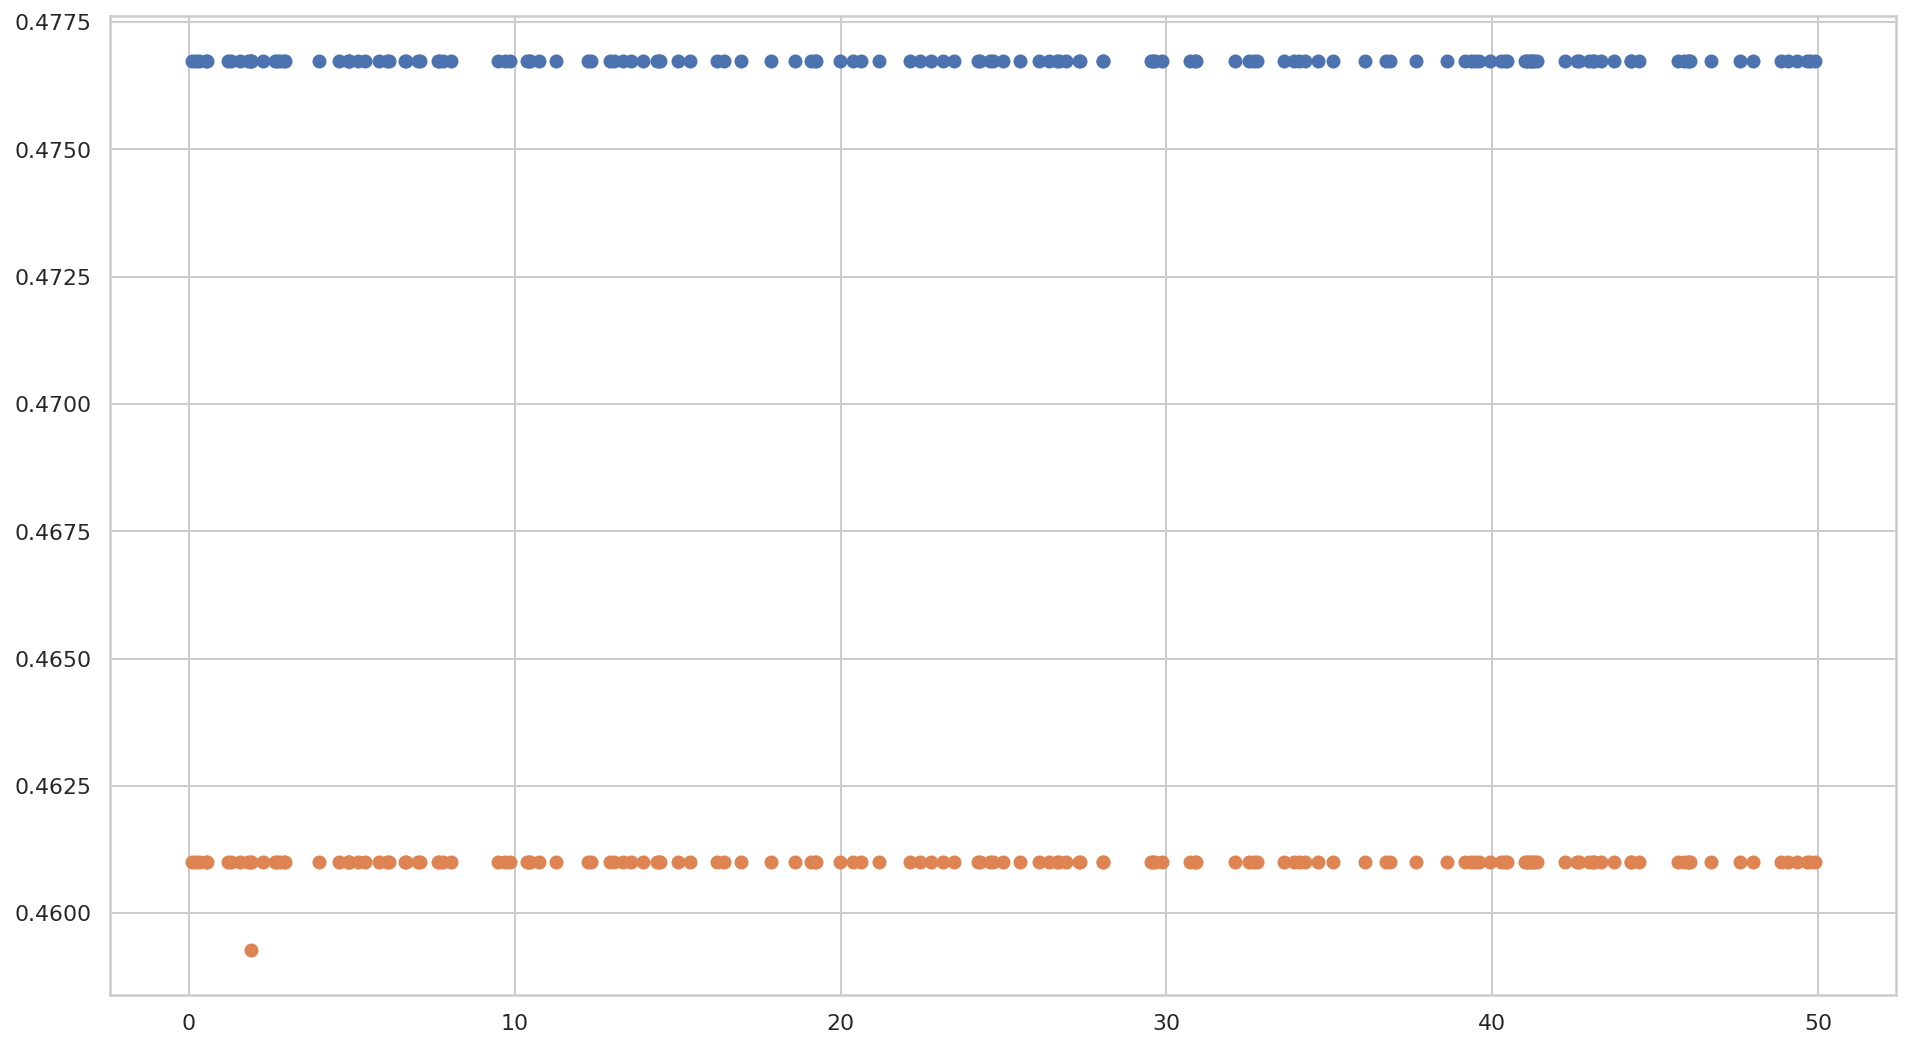

In [249]:
x = gs.cv_results_['param_w1'].data
y = gs.cv_results_['split1_test_score']
plt.figure()
plt.scatter(x,y)
y = gs.cv_results_['split0_test_score']
plt.scatter(x,y)

In [250]:
re = RecommendationEstimator(UF.copy(), IF.copy(), 5, 0.5, remove_seen=True) # not changing UF matrix
X = logs["user_id timestamp".split()].values
y = logs["item_id like".split()].values

In [251]:
%%time
re.score(X, y)

CPU times: user 4.02 s, sys: 0 ns, total: 4.02 s
Wall time: 4.02 s


0.45937090432503275

# Lengths of IF vectors

In [257]:
Lif = [norm(x) for x in IF]
print(f'minLength = {np.min(Lif):.4f} ; maxLength = {np.max(Lif):.4f} ratio = {np.max(Lif)/np.min(Lif):.4f}')

minLength = 0.0050 ; maxLength = 1.2619 ratio = 252.4611
